**<h1> Mortality Predictions in ICU using ANN** 
    
Patients admitted to the ICU suffer from critical illness or injury and are at high risk of dying. ICU mortality rates differ widely depending on the underlying disease process, with death rates as low as 1 in 20 for patients admitted following elective surgery, and as high as 1 in 4 for patients with respiratory diseases. The risk of death can be approximated by evaluating the severity of a patient’s illness as determined by important physiologic, clinical, and demographic determinants.

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd
import math 
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
import keras

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualisations
%matplotlib inline
sns.set_style( 'white' )

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/ANN/train.csv', encoding = 'utf-8')

In [4]:
labels = pd.read_csv('/content/drive/MyDrive/ANN/labels.csv', encoding = 'utf-8')

**<h2> Exploratory Data Analysis**

Henceforth, we will be doing the exploratory data analysis in order to identify the significant parameters contributing to the mortality rate and neglecting the rest.

In [5]:
df.head()

,ALP,ALT,AST,Age,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,DiasABP,FiO2,GCS,Gender,Glucose,HCO3,HCT,HR,Height,ICUType,K,Lactate,MAP,MechVent,Mg,NIDiasABP,NIMAP,NISysABP,Na,PaCO2,PaO2,Platelets,RecordID,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,Weight,pH
0,77.0,31.0,46.0,54,2.973333,10.500000,0.7,154.0,0.750000,58.795833,0.526667,14.923077,0,160.000000,27.000000,32.500000,70.810811,170.2,4,4.20,1.900000,78.934007,1,1.700000,50.147059,71.559118,114.382353,136.500000,39.666667,138.871212,203.000000,132539.0,17.428571,97.250000,116.891892,37.357143,2.1,0.14,171.052632,10.300000,80.060976,7.387273
1,77.0,31.0,46.0,76,2.973333,18.333333,0.7,154.0,1.100000,58.897059,0.560000,13.333333,1,125.500000,22.333333,28.655556,80.794118,175.3,2,3.90,1.900000,76.940299,1,2.300000,56.714286,75.308571,112.500000,137.000000,38.857143,210.142857,178.600000,132540.0,19.000000,96.833333,113.411765,36.939130,2.1,0.14,151.560976,11.266667,80.670588,7.395000
2,116.0,83.0,199.5,44,2.500000,4.666667,2.9,154.0,0.333333,67.125000,0.500000,5.923077,0,134.333333,25.000000,28.460000,83.759259,170.2,3,4.26,1.366667,90.437500,1,1.720000,79.000000,96.751316,132.263158,138.333333,35.500000,134.500000,89.666667,132541.0,19.000000,95.000000,125.687500,37.800000,2.1,0.14,124.951220,4.700000,56.700000,7.495000
3,105.0,12.0,15.0,68,4.400000,17.666667,0.2,154.0,0.766667,58.795833,0.526667,14.944444,1,117.333333,27.666667,37.442857,70.983333,180.3,3,4.00,1.900000,78.934007,1,2.033333,65.051724,83.885517,121.551724,139.333333,39.666667,138.871212,330.000000,132543.0,15.457627,97.250000,116.891892,36.223077,2.1,0.14,545.833333,9.400000,84.600000,7.387273
4,77.0,31.0,46.0,88,3.300000,35.000000,0.7,154.0,1.000000,58.795833,0.526667,15.000000,0,102.500000,19.000000,29.550000,74.958333,170.2,3,4.32,1.900000,78.934007,1,1.550000,45.720930,74.946512,133.395349,139.500000,39.666667,138.871212,103.000000,132545.0,19.166667,97.250000,116.891892,36.880000,2.1,0.14,62.131579,4.300000,80.060976,7.387273


In [6]:
df.columns

Index(['ALP', 'ALT', 'AST', 'Age', 'Albumin', 'BUN', 'Bilirubin',
       'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Gender',
       'Glucose', 'HCO3', 'HCT', 'HR', 'Height', 'ICUType', 'K', 'Lactate',
       'MAP', 'MechVent', 'Mg', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Na',
       'PaCO2', 'PaO2', 'Platelets', 'RecordID', 'RespRate', 'SaO2', 'SysABP',
       'Temp', 'TroponinI', 'TroponinT', 'Urine', 'WBC', 'Weight', 'pH'],
      dtype='object')

In [7]:
df.shape

(3999, 42)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 42 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ALP          3999 non-null   float64
 1   ALT          3999 non-null   float64
 2   AST          3999 non-null   float64
 3   Age          3999 non-null   int64  
 4   Albumin      3999 non-null   float64
 5   BUN          3999 non-null   float64
 6   Bilirubin    3999 non-null   float64
 7   Cholesterol  3999 non-null   float64
 8   Creatinine   3999 non-null   float64
 9   DiasABP      3999 non-null   float64
 10  FiO2         3999 non-null   float64
 11  GCS          3999 non-null   float64
 12  Gender       3999 non-null   int64  
 13  Glucose      3999 non-null   float64
 14  HCO3         3999 non-null   float64
 15  HCT          3999 non-null   float64
 16  HR           3999 non-null   float64
 17  Height       3999 non-null   float64
 18  ICUType      3999 non-null   int64  
 19  K     

In [9]:
df.describe()

,ALP,ALT,AST,Age,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,DiasABP,FiO2,GCS,Gender,Glucose,HCO3,HCT,HR,Height,ICUType,K,Lactate,MAP,MechVent,Mg,NIDiasABP,NIMAP,NISysABP,Na,PaCO2,PaO2,Platelets,RecordID,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,Weight,pH
count,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.0,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000
mean,89.259978,91.709903,130.219258,64.247562,2.975942,25.449665,1.216527,152.403601,1.363130,59.262693,106.243369,11.615267,35.335834,137.087758,23.674534,31.424746,87.122729,169.945036,36.175544,4.136466,2.145524,80.449634,1.0,2.017580,57.209247,76.101723,117.045472,138.861354,40.255572,180.324554,204.987649,137605.348587,19.223967,96.940907,118.145550,36.956291,2.368702,0.337362,133.363074,12.521058,82.799384,7.488870
std,70.397850,427.290858,590.482153,17.563142,0.404440,20.586576,2.961385,13.891279,1.406947,9.080069,3858.226228,3.235578,2198.997715,39.938339,4.178864,4.510583,14.550804,14.805887,2113.064930,0.522405,1.792110,11.656091,0.0,0.304457,10.925580,11.306395,18.226100,4.053181,7.012932,2188.040909,102.494600,2922.264561,2.074830,2.296143,16.540816,0.727382,2.418656,1.276145,117.304284,6.466063,23.117431,2.986373
min,12.000000,3.000000,6.000000,15.000000,1.100000,2.250000,0.100000,0.000000,0.200000,0.000000,0.276000,1.000000,0.000000,49.000000,9.125000,16.600000,3.000000,1.800000,1.000000,2.500000,0.400000,2.000000,1.0,1.100000,0.000000,0.000000,0.000000,111.500000,16.000000,26.000000,8.200000,132539.000000,10.543478,38.800000,0.000000,21.644615,0.300000,0.010000,0.000000,0.100000,3.500000,6.311667
25%,77.000000,31.000000,46.000000,52.500000,2.973333,13.000000,0.700000,154.000000,0.700000,55.843712,0.500000,9.307692,0.000000,112.250000,21.333333,28.300000,77.270209,170.200000,2.000000,3.800000,1.784524,75.481103,1.0,1.840000,50.492031,69.111667,105.812937,136.500000,37.333333,116.900000,137.450000,135078.000000,19.000000,97.230769,111.099359,36.614286,2.100000,0.125000,74.044118,8.900000,68.201064,7.364142
50%,77.000000,31.000000,46.000000,67.000000,2.973333,19.000000,0.700000,154.000000,0.933333,58.795833,0.526667,12.428571,1.000000,129.800000,23.666667,30.630952,86.274510,170.200000,3.000000,4.075000,1.900000,78.934007,1.0,2.000000,56.280788,74.751250,115.366987,139.000000,39.666667,138.871212,187.200000,137589.000000,19.000000,97.250000,116.891892,36.968750,2.100000,0.140000,111.032258,11.466667,80.060976,7.387273
75%,82.000000,32.250000,49.000000,78.000000,3.000000,30.000000,0.700000,154.000000,1.366667,62.210006,0.562500,14.750000,1.000000,152.250000,26.000000,34.017143,96.473258,170.200000,4.000000,4.400000,2.000000,83.204416,1.0,2.150000,63.166667,81.739195,126.645833,141.000000,42.000000,163.732143,246.900000,140099.500000,19.290323,97.250000,123.504098,37.364401,2.100000,0.140000,160.419207,14.950000,93.040476,7.407500
max,1472.333333,9143.428571,15680.000000,90.000000,5.300000,170.833333,46.366667,330.000000,16.457143,106.666667,141264.000000,15.000000,139060.000000,467.333333,96.000000,61.050000,137.842105,431.800000,133628.000000,16.000000,85.000000,265.000000,1.0,6.900000,107.500000,132.540000,234.000000,164.533333,158.000000,138477.000000,925.666667,142673.000000,39.655172,100.000000,181.725000,39.748980,49.200000,24.040000,3082.380952,137.233333,300.000000,128.532500


In [10]:
labels.shape

(3999, 1)

In [11]:
labels

,In-hospital_death
0,0
1,0
2,0
3,0
4,0
...,...
3994,0
3995,0
3996,0
3997,1


In [12]:
labels["In-hospital_death"].value_counts()

0    3445
1     554
Name: In-hospital_death, dtype: int64

In [13]:
#One Hot encoding
temp  =[]
for i in labels["In-hospital_death"]:
  if i == 0:
    temp.append([1,0])
  else:
    temp.append([0,1])
temp = np.array(temp)

In [14]:
print(temp.shape)

(3999, 2)


In [15]:
new = pd.concat([df , labels] , axis = 1)
print(new.shape)

(3999, 43)


**<h3>Using Correlation heatmap to find important features and their relations with other features.**

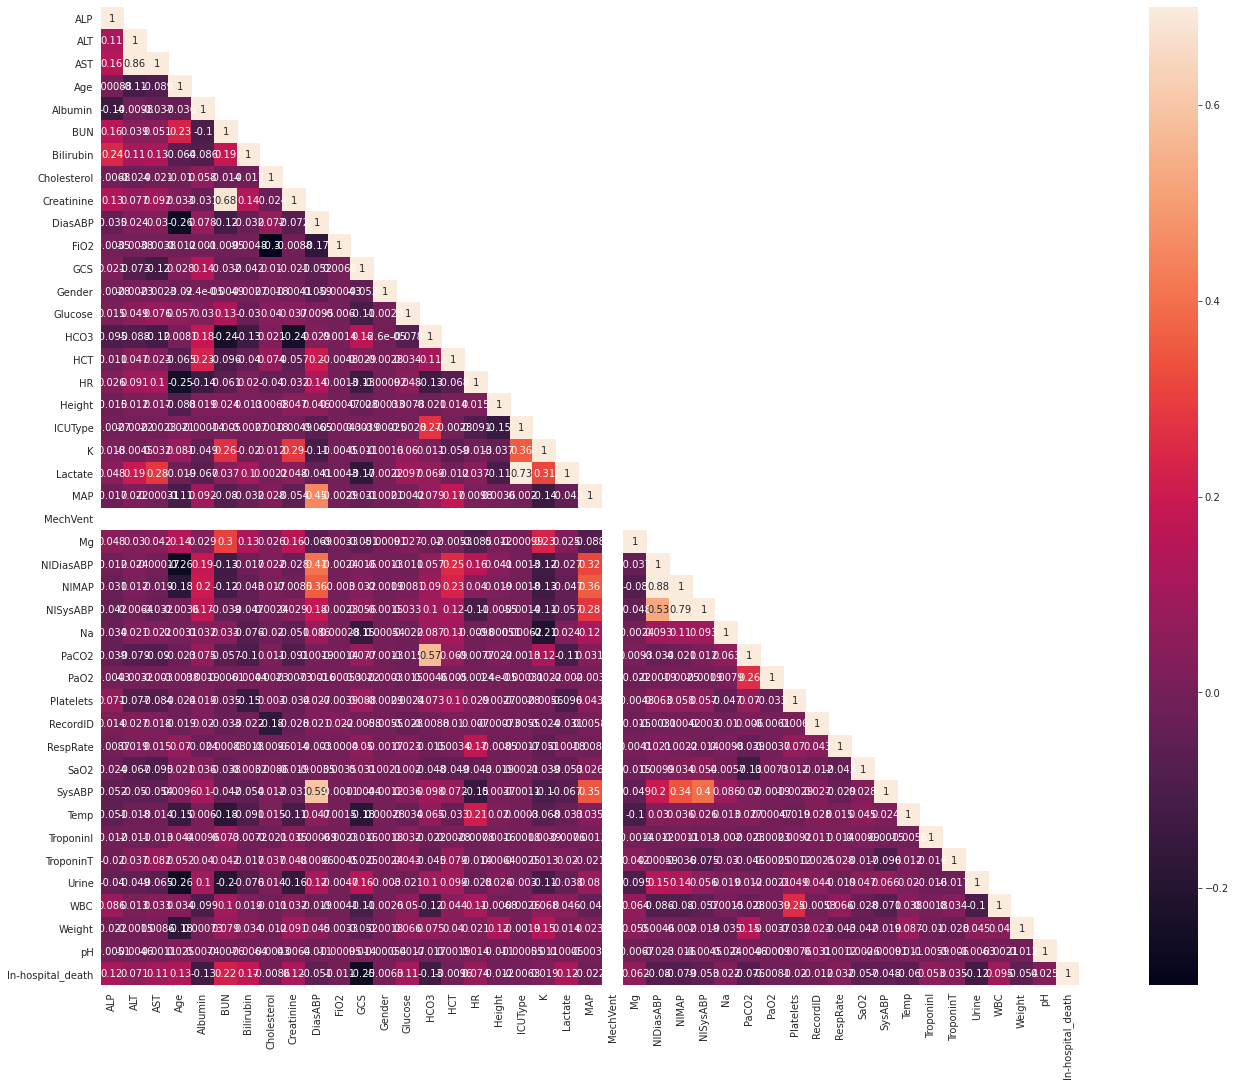

In [16]:
correlation_map = new[new.columns].corr()
obj = np.array(correlation_map)
obj[np.tril_indices_from(obj)] = False
fig,ax= plt.subplots()
fig.set_size_inches(25,18)
sns.heatmap(correlation_map, mask=obj,vmax=.7, square=True,annot=True)

In [17]:
new_df = new.drop(['In-hospital_death'] , axis =1)
new_df.shape

(3999, 42)

In [18]:
df = new_df

In [19]:
df = df.drop(['Gender','Cholesterol','HCT','ICUType','Height'] , axis =1)

**<h3> Scaling Data**

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

**<H2> Deep Learning Model**

Dataframe df will be given as X parameter and Inhospitaldeath case will be given as Y.

In [21]:
X = df
y = temp

In [22]:
print(X.shape , y.shape)

(3999, 37) (3999, 2)


**<h3>Splitting Dataset**

In [23]:
X_train , X_test , y_train , y_test  = train_test_split(X , y , test_size = 0.2)

In [24]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3199, 37) (800, 37) (3199, 2) (800, 2)


Importing necessary files.

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout , BatchNormalization
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.optimizers import RMSprop, Adam

**<h3> Building ANN Model**

In [26]:
model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1] , activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(196, activation='relu'))
model.add(Dense(196, activation='relu'))

model.add(BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer = Adam(lr = 0.0005),loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2432      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 196)               25284     
_________________________________________________________________
dense_3 (Dense)              (None, 196)               38612     
_________________________________________________________________
batch_normalization (BatchNo (None, 196)               784       
_________________________________________________________________
dense_4 (Dense)              (None, 256)               50432     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 5

**<h3> Fitting the model**


In [27]:
history = model.fit(X_train, y_train , epochs=15 , batch_size = 128 , validation_data=(X_test, y_test))

Epoch 1/15
25/25 [==============================] - 16s 26ms/step - loss: 0.5334 - accuracy: 0.7813 - val_loss: 0.5773 - val_accuracy: 0.8687
Epoch 2/15
25/25 [==============================] - 0s 5ms/step - loss: 0.3534 - accuracy: 0.8588 - val_loss: 0.5667 - val_accuracy: 0.8687
Epoch 3/15
25/25 [==============================] - 0s 8ms/step - loss: 0.3144 - accuracy: 0.8719 - val_loss: 0.5649 - val_accuracy: 0.8687
Epoch 4/15
25/25 [==============================] - 0s 6ms/step - loss: 0.3112 - accuracy: 0.8751 - val_loss: 0.5480 - val_accuracy: 0.8700
Epoch 5/15
25/25 [==============================] - 0s 6ms/step - loss: 0.3144 - accuracy: 0.8706 - val_loss: 0.4825 - val_accuracy: 0.8687
Epoch 6/15
25/25 [==============================] - 0s 6ms/step - loss: 0.3083 - accuracy: 0.8814 - val_loss: 0.4816 - val_accuracy: 0.8687
Epoch 7/15
25/25 [==============================] - 0s 5ms/step - loss: 0.3065 - accuracy: 0.8702 - val_loss: 0.4603 - val_accuracy: 0.8687
Epoch 8/15
25/25 [

**<h3> Evaluating Performance using Accuracy ,Loss and Confusion Matrix**



In [28]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


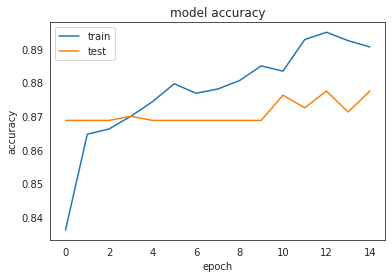

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

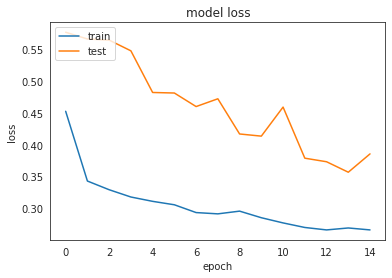

In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix
#prediction
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

In [32]:
cnf_matrix = confusion_matrix(y_true, pred)
print(cnf_matrix)

[[691   4]
 [ 94  11]]


In [ ]:
print(accuracy_score(y_true,pred))

0.87


**<h2> Summary**

The above model has a loss of 0.27 and an accuracy of about 88%. This is the maximum accuracy it can reach with the given size of data. 

This model can be successfully used for predicting mortality in ICUs but then one should keep in mind that these values are just predicted values and the predictions can be wrong.